<a href="https://colab.research.google.com/github/jerrybaba10/jerrybaba10/blob/main/Regression/DigitalGreen_Starter_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import datetime as dt
import scipy.stats as st


WE will use ensemble models like XGBoost, and LightGBM later for improvement.

We will implement and compare bagging, boosting, randomforest, stacking.

In [ ]:
# Load files
data_path = '/content/'
train = pd.read_csv(data_path + 'Train.csv')
test = pd.read_csv(data_path + 'Test.csv')
sample_submission = pd.read_csv(data_path + 'SampleSubmission.csv')
var_desc = pd.read_csv(data_path + 'VariableDescription.csv')

In [ ]:
var_desc

,Variable,Description
0,District,Name of the district
1,Block,Name of the block
2,CultLand,Area of total cultivated land
3,CropCultLand,Area of land under cultivation
4,LandPreparationMethod,Method for land preparation
5,CropTillageDate,Date of tillage of the largest plot
6,CropTillageDepth,Depth of the tillage
7,CropEstMethod,Method of transplantation
8,RcNursEstDate,Date of nursery establishment
9,SeedingSowingTransplanting,Date of sowing/Transplanting the crop


In [ ]:
# Relevant features
ls = ['District','CropTillageDate','CropTillageDepth','CropEstMethod','SeedingSowingTransplanting',
'SeedlingsPerPit','TransplantingIrrigationHours','StandingWater','Ganaura','CropOrgFYM',
'PCropSolidOrgFertAppMethod','NoFertilizerAppln','BasalDAP','BasalUrea','MineralFertAppMethod','1tdUrea',
'1appDaysUrea', '2tdUrea','2appDaysUrea','Harv_method','Threshing_method','Residue_length','Stubble_use',"Acre"]
len(ls)

24

In [ ]:

(train.Block[train['District'] == 'Gaya'])

2           Gurua
3           Gurua
16          Gurua
29          Gurua
41          Gurua
          ...    
3814        Gurua
3820        Gurua
3833        Gurua
3839        Gurua
3844    Wazirganj
Name: Block, Length: 570, dtype: object

In [ ]:

(train.Block[train['District'] == 'Jamui']).info()

<class 'pandas.core.series.Series'>
Int64Index: 1127 entries, 6 to 3869
Series name: Block
Non-Null Count  Dtype 
--------------  ----- 
1127 non-null   object
dtypes: object(1)
memory usage: 17.6+ KB


In [ ]:
train['Block'].unique(),train['District'].unique()

(array(['Noorsarai', 'Rajgir', 'Gurua', 'Garoul', 'Khaira', 'Jamui',
        'Mahua', 'Chehrakala', 'Wazirganj'], dtype=object),
 array(['Nalanda', 'Gaya', 'Vaishali', 'Jamui'], dtype=object))

After reviewing the features, some don't seem relevant for training our models we will be dropping them. Also, the dates columns are convert to datetime stamp.  

In [ ]:
def fill_na(df):
  columns_1 = df.select_dtypes(include= np.number)
  columns_2 = df.select_dtypes(exclude= np.number)

  # fill the numeric columns
  for col in columns_1:
    df[col].fillna(df[col].median(), inplace = True)

  # fill the non-numeric columns
  for col_ in columns_2:
    mode_value =  df[col_].mode()[0]
    df[col_].fillna(mode_value, inplace = True)
  return df

def clean_data(df,drop_columns, date_columns):
  df = df.drop(drop_columns, axis=1)
  for column in date_columns:
    df[column] = pd.to_datetime(df[column]).dt.month
  # filling null values
  df = fill_na(df)
  df = pd.get_dummies(df, drop_first=True)

  return df

In [ ]:
drop_columns = ['ID','Block', 'CultLand','CropCultLand','LandPreparationMethod','RcNursEstDate',
'NursDetFactor', 'TransDetFactor','TransplantingIrrigationSource','TransplantingIrrigationPowerSource',
 'TransIrriCost','OrgFertilizers','CropbasalFerts','FirstTopDressFert','MineralFertAppMethod.1',
 'Harv_date','Harv_hand_rent','Threshing_date']

df1 = train.drop(drop_columns, axis=1)

In [ ]:
# Preview files

date_columns = ['CropTillageDate','SeedingSowingTransplanting']
for column in date_columns:
  df1[column] = pd.to_datetime(df1[column]).dt.month


df1.head()

,District,CropTillageDate,CropTillageDepth,CropEstMethod,SeedingSowingTransplanting,SeedlingsPerPit,TransplantingIrrigationHours,StandingWater,Ganaura,CropOrgFYM,...,1appDaysUrea,2tdUrea,2appDaysUrea,Harv_method,Threshing_method,Residue_length,Residue_perc,Stubble_use,Acre,Yield
0,Nalanda,7,5,Manual_PuddledRandom,7,2.0,5.0,2.0,NaN,NaN,...,18.0,NaN,NaN,machine,machine,30,40,plowed_in_soil,0.312500,600
1,Nalanda,7,5,Manual_PuddledRandom,7,2.0,5.0,3.0,NaN,NaN,...,39.0,NaN,NaN,hand,machine,24,10,plowed_in_soil,0.312500,600
2,Gaya,6,6,Manual_PuddledRandom,8,2.0,4.0,2.0,1.0,1.0,...,65.0,NaN,NaN,hand,machine,30,10,plowed_in_soil,0.148148,225
3,Gaya,6,6,Manual_PuddledRandom,7,2.0,NaN,NaN,1.0,NaN,...,5.0,NaN,NaN,hand,hand,26,10,plowed_in_soil,0.222222,468
4,Nalanda,7,4,Manual_PuddledRandom,7,2.0,9.0,2.0,NaN,NaN,...,26.0,NaN,NaN,machine,machine,24,40,plowed_in_soil,0.468750,550


In [ ]:
df1.describe()

,CropTillageDate,CropTillageDepth,SeedingSowingTransplanting,SeedlingsPerPit,TransplantingIrrigationHours,StandingWater,Ganaura,CropOrgFYM,NoFertilizerAppln,BasalDAP,BasalUrea,1tdUrea,1appDaysUrea,2tdUrea,2appDaysUrea,Residue_length,Residue_perc,Acre,Yield
count,3870.000000,3870.000000,3870.000000,3581.000000,3677.000000,3632.000000,1453.000000,1196.000000,3870.000000,3327.000000,2166.000000,3314.000000,3314.000000,1176.000000,1170.000000,3870.000000,3870.000000,3870.000000,3870.000000
mean,6.803359,4.488372,7.289406,2.706507,8.017677,3.247522,29.731590,57.445652,2.184496,11.452359,13.351801,11.513881,29.200362,7.375000,58.764957,26.517829,11.767442,0.292826,594.269251
std,0.459065,1.133044,0.453545,7.624397,42.612470,2.207276,122.680882,328.251615,0.634632,8.422049,9.701597,8.715856,12.139109,5.932502,11.356588,3.192873,7.064864,0.206918,651.916953
min,5.000000,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,10.000000,0.045455,4.000000
25%,7.000000,4.000000,7.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,6.000000,7.000000,6.000000,23.000000,4.000000,58.000000,25.000000,10.000000,0.156250,300.000000
50%,7.000000,4.000000,7.000000,2.000000,4.000000,3.000000,3.000000,2.000000,2.000000,10.000000,10.000000,10.000000,28.000000,6.000000,60.000000,26.000000,10.000000,0.227273,425.000000
75%,7.000000,5.000000,8.000000,3.000000,6.000000,4.000000,4.000000,5.000000,3.000000,15.000000,16.000000,15.000000,36.000000,10.000000,65.000000,30.000000,10.000000,0.370370,740.000000
max,8.000000,8.000000,8.000000,442.000000,2000.000000,15.000000,1400.000000,4000.000000,4.000000,100.000000,90.000000,90.000000,332.000000,67.000000,97.000000,30.000000,40.000000,2.187500,16800.000000


There are no obvious outliers on our dataset.

#### Lets work on the  null values

In [ ]:



df2 = df1.copy()
df2 = fill_na(df2)

# df2.head()

In [ ]:
df2.isnull().any().sum()

0

Good, no more null values

### Time to encode our data

We will perform one hot encoding of the following features:

[['District','CropEstMethod', 'PCropSolidOrgFertAppMethod','MineralFertAppMethod',
                          'Harv_method','Threshing_method','Stubble_use']]

```
# This is formatted as code
```




In [ ]:
df3 = df2.copy()
df3 = pd.get_dummies(df3, drop_first=True)
df3.head()

,CropTillageDate,CropTillageDepth,SeedingSowingTransplanting,SeedlingsPerPit,TransplantingIrrigationHours,StandingWater,Ganaura,CropOrgFYM,NoFertilizerAppln,BasalDAP,...,CropEstMethod_Manual_PuddledLine,CropEstMethod_Manual_PuddledRandom,PCropSolidOrgFertAppMethod_RootApplication,PCropSolidOrgFertAppMethod_SoilApplied,PCropSolidOrgFertAppMethod_Spray,MineralFertAppMethod_RootApplication,MineralFertAppMethod_SoilApplied,Harv_method_machine,Threshing_method_machine,Stubble_use_plowed_in_soil
0,7,5,7,2.0,5.0,2.0,3.0,2.0,2,10.0,...,0,1,0,1,0,0,0,1,1,1
1,7,5,7,2.0,5.0,3.0,3.0,2.0,2,15.0,...,0,1,0,1,0,0,0,0,1,1
2,6,6,8,2.0,4.0,2.0,1.0,1.0,2,4.0,...,0,1,0,1,0,0,1,0,1,1
3,6,6,7,2.0,4.0,3.0,1.0,2.0,2,6.0,...,0,1,0,1,0,0,0,0,0,1
4,7,4,7,2.0,9.0,2.0,3.0,2.0,2,15.0,...,0,1,0,1,0,0,0,1,1,1


In [ ]:
df3.shape

(3870, 33)

### Lets clean the test data as well.
Notice that the 'MineralFertAppMethod' column in the test set contains 'Spray' as an element, which is not in the train set. So lets replace it with the mode of that set which is 'Broadcasting'.

In [ ]:
train.MineralFertAppMethod.unique(), test.MineralFertAppMethod.unique()

(array(['Broadcasting', 'SoilApplied', 'RootApplication'], dtype=object),
 array(['Broadcasting', 'SoilApplied', 'RootApplication', 'Spray'],
       dtype=object))

In [ ]:
test['MineralFertAppMethod'].replace('Spray', 'Broadcasting', inplace=True)
test.MineralFertAppMethod.unique()

array(['Broadcasting', 'SoilApplied', 'RootApplication'], dtype=object)

In [ ]:
X_train = clean_data(train, drop_columns, date_columns)
X_test = clean_data(test, drop_columns, date_columns)

X_train.shape, X_test.shape

((3870, 33), (1290, 32))

Cleaning the

### Time for scaling the data

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
X = X_train.drop('Yield', axis=1)
y = X_train.Yield

In [ ]:
scaler = StandardScaler()

scaler.fit(X)
X_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn import svm
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
# Split data for training and local testing

x_train, x_val, y_train, y_val = train_test_split(X_scaled, y, test_size = 0.25,
                                                  random_state = 1234)

# Instantiate model
model = svm.LinearSVR(C =50,max_iter=1000 )

# Fit model
model.fit(x_train, y_train)

# Make predictions
preds = model.predict(x_val)

# Measure model performance
mean_squared_error(y_val, preds, squared=False)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


410.0444359302656

Best models so far
GradientBoostingRegressor(learning_rate=0.05, min_samples_leaf=2, max_depth = 3, min_samples_split=6, n_estimators=500)

giving us mse = 385.5889

In [ ]:

# Create a base estimator
# base_estimator = DecisionTreeRegressor()
base_estimator = GradientBoostingRegressor(learning_rate=0.05, n_estimators=500)

# Create the Bagging model
bagging_model = BaggingRegressor(estimator= base_estimator)

# Fit the model to the training data
bagging_model.fit(x_train, y_train)

# Predict on the test data
preds = bagging_model.predict(x_val)

# Measure model performance
mean_squared_error(y_val, preds, squared=False)

425.4610585229172

In [ ]:
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor,StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [ ]:

# Create different base models
linear_model = LinearRegression()
tree_model = DecisionTreeRegressor()
tree_model_grid = DecisionTreeRegressor()
svm_model = SVR(kernel='linear')

# Create a BaggingRegressor with different base models

# bagging_linear = BaggingRegressor(estimator=linear_model, n_estimators=10, random_state=42)
bagging_tree = BaggingRegressor(estimator=tree_model, n_estimators=10, random_state=42)
# bagging_svm = BaggingRegressor(estimator=svm_model, n_estimators=10, random_state=42)
# bagging_tree_grid = BaggingRegressor(estimator=tree_model_grid,
#                                      n_estimators=10, random_state=42)

# Fit and evaluate each BaggingRegressor
# for model, name in zip([bagging_linear, bagging_tree, bagging_svm,tree_model_grid ], ['Linear', 'Decision Tree',
#                                                                      'SVM', 'grid Tree']):
bagging_tree.fit(x_train, y_train)
y_pred = bagging_tree.predict(x_val)
mse = mean_squared_error(y_val, y_pred, squared=False)
mse


383.35719712375067

### Our Best model so far is bagging with Decision tree regressor as shown above

## Lets perform feature engineering

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt



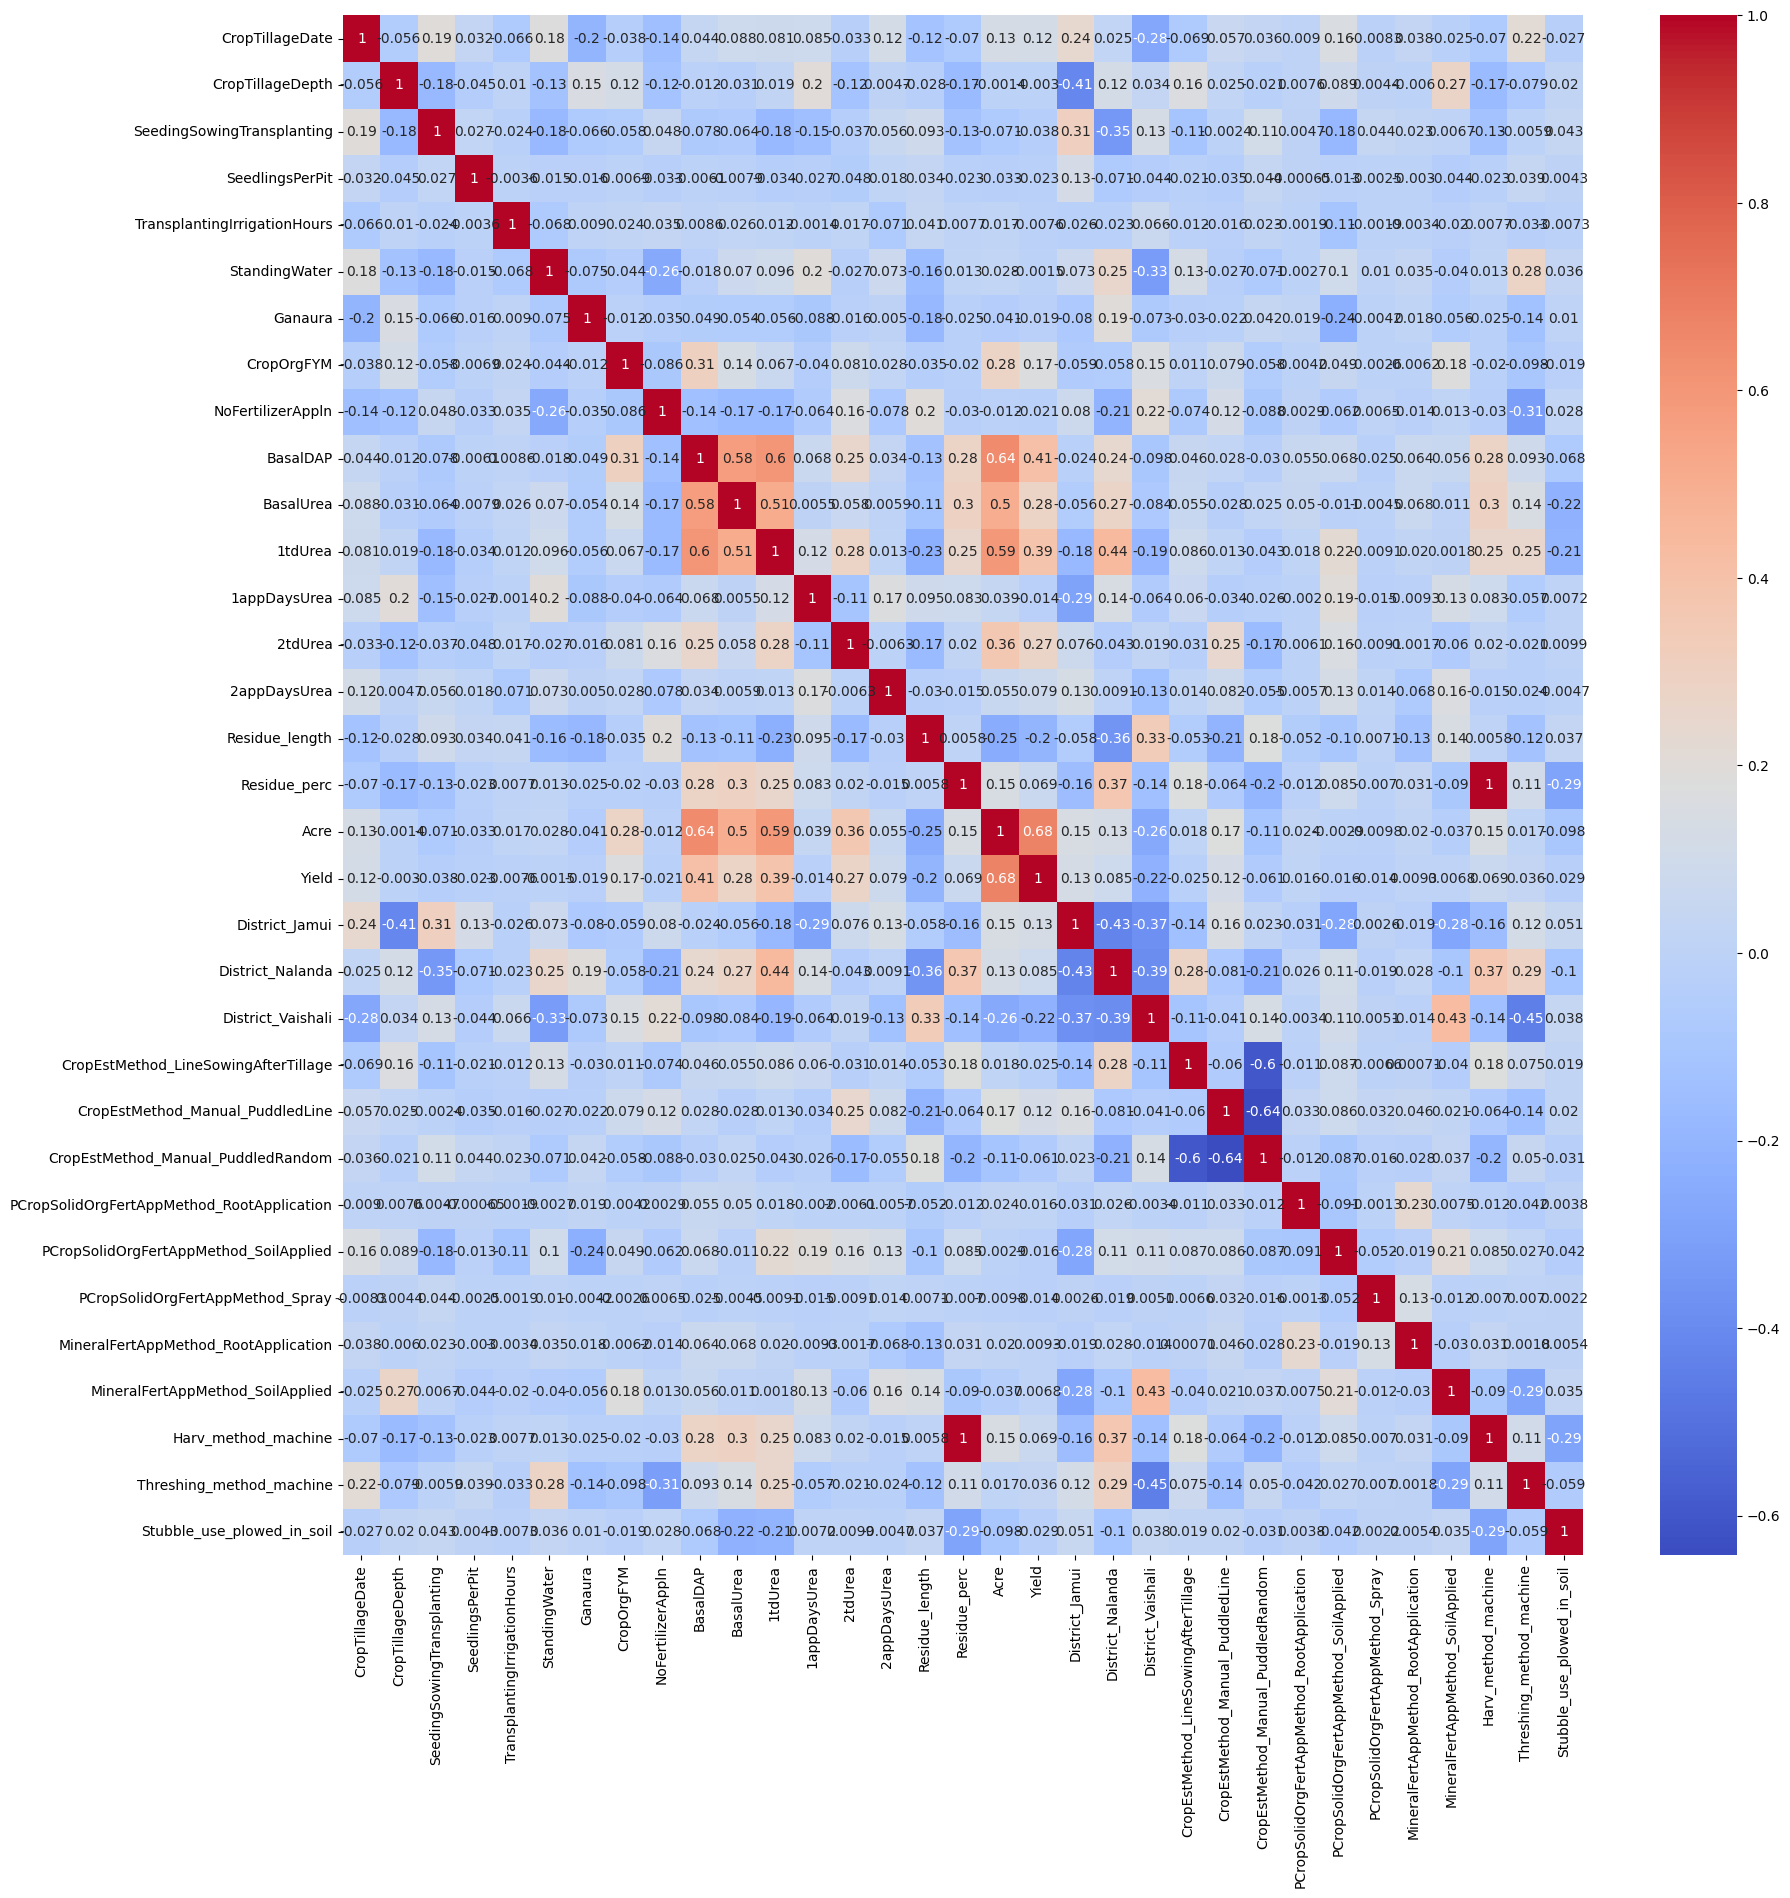

In [ ]:
# Generate a correlation matrix
corr_matrix = X_train.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Show the plot
# plt.figure(figsize=(15, 15))
plt.show()

In [ ]:
from sklearn.decomposition import PCA

# Instantiate the PCA object
pca = PCA(0.95)

# Fit the PCA model to the data
pca.fit(X_scaled)

# Transform the data to the principal components
X_pca = pca.transform(X_scaled)


In [ ]:
pca.n_components_

25

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X_pca, y, test_size = 0.25,
                                                  random_state = 1234)

In [ ]:

# Create different base models
linear_model = LinearRegression()
tree_model = DecisionTreeRegressor()
tree_model_grid = DecisionTreeRegressor()
svm_model = SVR(kernel='linear')

# Create a BaggingRegressor with different base models

bagging_linear = BaggingRegressor(estimator=linear_model, n_estimators=10, random_state=42)
bagging_tree = BaggingRegressor(estimator=tree_model, n_estimators=10, random_state=42)
bagging_svm = BaggingRegressor(estimator=svm_model, n_estimators=10, random_state=42)
bagging_tree_grid = BaggingRegressor(estimator=tree_model_grid,
                                     n_estimators=500, random_state=42)

# Fit and evaluate each BaggingRegressor
for model in [bagging_linear, bagging_tree, bagging_svm,bagging_tree_grid]:
  model.fit(x_train, y_train)
  y_pred = model.predict(x_val)
  mse = mean_squared_error(y_val, y_pred, squared=False)
  print(mse)


421.03296857018836
484.34287974274383
439.1409175553911
436.2084704737313


In [ ]:
# Make predictions on the Zindi test set

preds = model.predict(X_test)

# Create submisiion file to be uploaded to Zindi for scoring
sub = pd.DataFrame({'ID': test.ID, 'Yield': preds})
sub.to_csv('2ndsubmission.csv', index = False)

sub.head()

,ID,Yield
0,ID_F9XXEXN2ADR2,629.977829
1,ID_SO3VW2X4QO93,476.546237
2,ID_UKUQ7JM8E894,456.719083
3,ID_QUISMWEZR2H4,318.131507
4,ID_25JGI455VKCZ,627.055300
